In [1]:
# Basic imports and environment checks
import os
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.utils import make_grid, save_image

print("PyTorch:", torch.__version__, "| CUDA:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# results
Path("results/alignment_run").mkdir(parents=True, exist_ok=True)


PyTorch: 2.6.0+cu124 | CUDA: True


In [3]:
import medmnist
from medmnist import INFO, PathMNIST, OrganAMNIST
from transformers import AutoTokenizer, AutoModel

# Choose LM
LM_NAME = "dmis-lab/biobert-v1.1"  # BioBERT
tokenizer = AutoTokenizer.from_pretrained(LM_NAME)
text_encoder = AutoModel.from_pretrained(LM_NAME).to(device)
text_encoder.eval()


c:\Users\saira\anaconda3\envs\matsuo\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [6]:
class CFG:
    dataset = "PathMNIST"
    img_size = 28
    batch_size = 64         # reduce to 32 if OOM
    epochs = 6              # small number for demo
    lr = 2e-4
    proj_dim = 128          # projection dimension for CLIP heads
    temp = 0.07
    device = device
    output_dir = Path("results/alignment_run")

cfg = CFG()

# Load dataset
DataClass = PathMNIST if cfg.dataset == "PathMNIST" else OrganAMNIST
transform = T.Compose([T.Resize((cfg.img_size, cfg.img_size)), T.ToTensor()])
train_ds = DataClass(split='train', transform=transform, download=True)
train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=2, pin_memory=True)

# try to get label->name mapping if INFO has it
DataClass = PathMNIST if cfg.dataset == "PathMNIST" else OrganAMNIST
info = INFO[cfg.dataset.lower()]
label_names = info.get('label', None)
print("Dataset:", cfg.dataset, "| Number of classes:", info.get('n_classes', 'unknown'))
print("Sample label mapping:", label_names)


Dataset: PathMNIST | Number of classes: unknown
Sample label mapping: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}


In [21]:
# Robust normalization of label_names -> list
label_names_list = []
if isinstance(label_names, dict):
    # Try to sort by integer key if possible (keys could be int or string numbers)
    try:
        # Convert keys to ints for sorting, falling back to original key if conversion fails
        items = sorted(label_names.items(), key=lambda kv: int(kv[0]))
        label_names_list = [v for k, v in items]
    except Exception:
        # If keys are non-numeric, just take the dict.values() order (or convert to list)
        label_names_list = list(label_names.values())
elif isinstance(label_names, (list, tuple)):
    label_names_list = list(label_names)
else:
    label_names_list = []

# Determine number of classes (use info if provided, but ensure it's at least as large as labels)
n_classes = info.get('n_classes', len(label_names_list) or 10)
n_classes = max(n_classes, len(label_names_list))

# Build label -> caption mapping safely
label2caption = {
    i: (label_names_list[i] if i < len(label_names_list) else f"class_{i}")
    for i in range(n_classes)
}

# Quick print to verify (shows only existing labels if info had larger n_classes)
for k in range(min(n_classes, len(label_names_list))):
    print(k, "->", label2caption[k])


0 -> adipose
1 -> background
2 -> debris
3 -> lymphocytes
4 -> mucus
5 -> smooth muscle
6 -> normal colon mucosa
7 -> cancer-associated stroma
8 -> colorectal adenocarcinoma epithelium


In [11]:
# Reuse a small encoder from previous TinyUNet code (encoder part only)
class TinyImageEncoder(nn.Module):
    def __init__(self, in_ch=1, base_ch=32):
        super().__init__()
        self.inc = nn.Sequential(
            nn.Conv2d(in_ch, base_ch, 3, padding=1),
            nn.GroupNorm(8, base_ch),
            nn.SiLU(),
            nn.Conv2d(base_ch, base_ch, 3, padding=1),
            nn.GroupNorm(8, base_ch),
            nn.SiLU(),
        )
        self.down1 = nn.Sequential(nn.AvgPool2d(2),
                                   nn.Conv2d(base_ch, base_ch*2, 3, padding=1),
                                   nn.GroupNorm(8, base_ch*2),
                                   nn.SiLU())
        self.down2 = nn.Sequential(nn.AvgPool2d(2),
                                   nn.Conv2d(base_ch*2, base_ch*4, 3, padding=1),
                                   nn.GroupNorm(8, base_ch*4),
                                   nn.SiLU())
        self.pool = nn.AdaptiveAvgPool2d(1)  # global pooling

    def forward(self, x):
        x = self.inc(x)
        x = self.down1(x)
        x = self.down2(x)
        x = self.pool(x)  # B x C x 1 x 1
        x = x.view(x.size(0), -1)  # B x C
        return x

# projection heads
class ProjectionHead(nn.Module):
    def __init__(self, in_dim, proj_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, in_dim//2),
            nn.ReLU(),
            nn.Linear(in_dim//2, proj_dim)
        )
    def forward(self, x):
        return self.net(x)

# instantiate
channels = 1 if info['n_channels'] == 1 else 3
img_encoder = TinyImageEncoder(in_ch=channels, base_ch=32).to(cfg.device)
# determine text embedding dim by passing a dummy text
with torch.no_grad():
    sample = tokenizer(["test"], return_tensors="pt", padding=True).to(cfg.device)
    out = text_encoder(**sample, return_dict=True)
    if hasattr(out, 'pooler_output') and out.pooler_output is not None:
        text_dim = out.pooler_output.shape[-1]
    else:
        text_dim = out.last_hidden_state.shape[-1]
print("Text embedding dim:", text_dim)

img_proj = ProjectionHead(in_dim=32*4, proj_dim=cfg.proj_dim).to(cfg.device)  # in_dim matches base_ch*4
txt_proj = ProjectionHead(in_dim=text_dim, proj_dim=cfg.proj_dim).to(cfg.device)


Text embedding dim: 768


In [12]:
@torch.no_grad()
def encode_texts(prompts, max_length=32):
    inputs = tokenizer(prompts, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to(cfg.device)
    out = text_encoder(**inputs, return_dict=True)
    if hasattr(out, "pooler_output") and out.pooler_output is not None:
        emb = out.pooler_output
    else:
        mask = inputs["attention_mask"].unsqueeze(-1)
        emb = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-9)
    return emb  # B x H


In [13]:
# NT-Xent (symmetric) implemented for a batch of image and text embeddings
def contrastive_loss(img_z, txt_z, temp=0.07):
    # img_z, txt_z: (B, D) already projected (not normalized)
    img_norm = img_z / (img_z.norm(dim=1, keepdim=True) + 1e-9)
    txt_norm = txt_z / (txt_z.norm(dim=1, keepdim=True) + 1e-9)
    logits = torch.matmul(img_norm, txt_norm.t()) / temp  # (B, B)
    targets = torch.arange(img_z.size(0), device=img_z.device).long()

    loss_i2t = nn.CrossEntropyLoss()(logits, targets)
    loss_t2i = nn.CrossEntropyLoss()(logits.t(), targets)
    return (loss_i2t + loss_t2i) / 2.0, logits.detach().cpu()


In [14]:
# Optionally freeze heavy text_encoder parameters (we already load it frozen above)
for p in text_encoder.parameters():
    p.requires_grad = False

# We'll train img_encoder + img_proj + txt_proj (small), keep text_encoder frozen
opt = torch.optim.Adam(list(img_encoder.parameters()) + list(img_proj.parameters()) + list(txt_proj.parameters()), lr=cfg.lr)

# training (quick demo)
img_encoder.train(); img_proj.train(); txt_proj.train()
losses = []
logits_log = []
steps = 0
max_steps_to_save = 5

for epoch in range(cfg.epochs):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{cfg.epochs}")
    for batch in pbar:
        imgs, labels = batch[0].to(cfg.device), batch[1].to(cfg.device).long().squeeze()
        imgs = imgs.float()
        # Prepare text captions per label
        captions = [label2caption[int(l.item())] for l in labels]
        with torch.no_grad():
            txt_emb = encode_texts(captions)  # (B, H)

        img_feat = img_encoder(imgs)          # (B, C)
        img_z = img_proj(img_feat)            # (B, proj_dim)
        txt_z = txt_proj(txt_emb)             # (B, proj_dim)

        loss, logits = contrastive_loss(img_z, txt_z, temp=cfg.temp)
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(float(loss.detach().cpu()))
        logits_log.append(logits)
        steps += 1
        pbar.set_postfix(loss=float(loss.detach().cpu()))

    # save checkpoint per epoch
    torch.save({
        'img_encoder': img_encoder.state_dict(),
        'img_proj': img_proj.state_dict(),
        'txt_proj': txt_proj.state_dict(),
        'optimizer': opt.state_dict(),
        'losses': losses
    }, cfg.output_dir / f"alignment_epoch_{epoch+1}.pt")
    print(f"Saved checkpoint for epoch {epoch+1}")


Epoch 1/6:   0%|          | 0/1407 [00:00<?, ?it/s]

Saved checkpoint for epoch 1


Epoch 2/6:   0%|          | 0/1407 [00:00<?, ?it/s]

Saved checkpoint for epoch 2


Epoch 3/6:   0%|          | 0/1407 [00:00<?, ?it/s]

Saved checkpoint for epoch 3


Epoch 4/6:   0%|          | 0/1407 [00:00<?, ?it/s]

Saved checkpoint for epoch 4


Epoch 5/6:   0%|          | 0/1407 [00:00<?, ?it/s]

Saved checkpoint for epoch 5


Epoch 6/6:   0%|          | 0/1407 [00:00<?, ?it/s]

Saved checkpoint for epoch 6


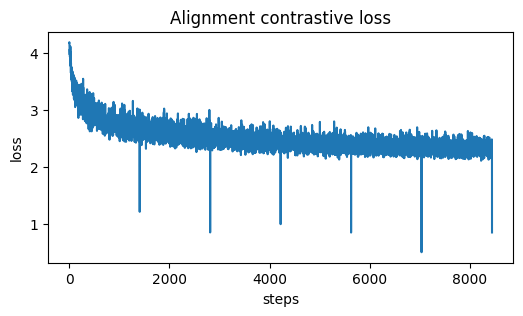

In [15]:
import numpy as np
if len(losses) > 0:
    plt.figure(figsize=(6,3))
    plt.plot(losses)
    plt.title("Alignment contrastive loss")
    plt.xlabel("steps")
    plt.ylabel("loss")
    plt.show()
else:
    print("No losses recorded.")


In [16]:
# Build embeddings for a subset (to visualize): take first N batches
img_encoder.eval(); img_proj.eval(); txt_proj.eval()
all_img_z = []
all_txt_z = []
all_labels = []
max_samples = 512
count = 0

with torch.no_grad():
    for batch in train_loader:
        imgs, labels = batch[0].to(cfg.device), batch[1].to(cfg.device).long().squeeze()
        imgs = imgs.float()
        captions = [label2caption[int(l.item())] for l in labels]
        txt_emb = encode_texts(captions)
        img_feat = img_encoder(imgs)
        img_z = img_proj(img_feat)
        txt_z = txt_proj(txt_emb)

        all_img_z.append(img_z.cpu())
        all_txt_z.append(txt_z.cpu())
        all_labels.append(labels.cpu())

        count += imgs.size(0)
        if count >= max_samples:
            break

all_img_z = torch.cat(all_img_z, dim=0)[:max_samples].numpy()
all_txt_z = torch.cat(all_txt_z, dim=0)[:max_samples].numpy()
all_labels = torch.cat(all_labels, dim=0)[:max_samples].numpy()
print("Prepared embeddings:", all_img_z.shape, all_txt_z.shape, all_labels.shape)


Prepared embeddings: (512, 128) (512, 128) (512,)


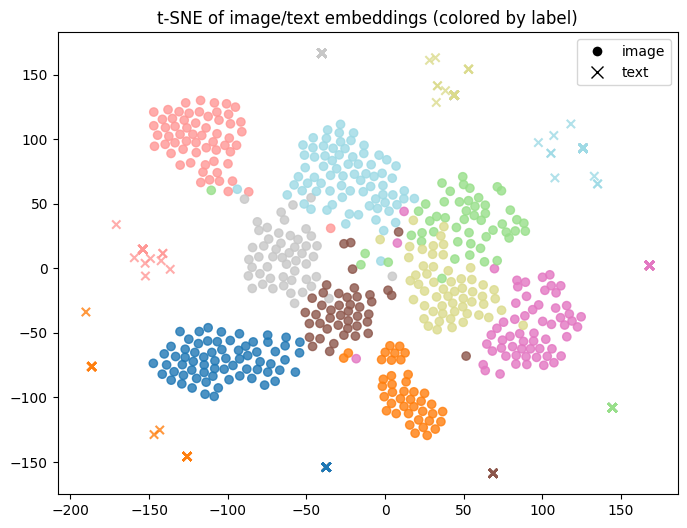

Saved t-SNE plot to: results\alignment_run\alignment_tsne.png


In [18]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# concatenate image and text embeddings to compute joint projection
concat = np.concatenate([all_img_z, all_txt_z], axis=0)  # (2N, D)

# PCA (fast)
pca = PCA(n_components=50)
pca_proj = pca.fit_transform(concat)

# t-SNE on PCA-projected space (use max_iter not n_iter)
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, init='pca', random_state=42)
tsne_proj = tsne.fit_transform(pca_proj)  # (2N, 2)

N = all_img_z.shape[0]
img_points = tsne_proj[:N]
txt_points = tsne_proj[N:2*N]

plt.figure(figsize=(8,6))
sc_img = plt.scatter(img_points[:,0], img_points[:,1], c=all_labels, cmap='tab20',
                     marker='o', alpha=0.8)
sc_txt = plt.scatter(txt_points[:,0], txt_points[:,1], c=all_labels, cmap='tab20',
                     marker='x', alpha=0.8)

# Create legend entries for markers
from matplotlib.lines import Line2D
legend_elems = [
    Line2D([0], [0], marker='o', color='w', label='image', markerfacecolor='k', markersize=8),
    Line2D([0], [0], marker='x', color='w', label='text', markeredgecolor='k', markersize=8)
]
plt.legend(handles=legend_elems)
plt.title("t-SNE of image/text embeddings (colored by label)")
plt.savefig(cfg.output_dir / "alignment_tsne.png", dpi=200)
plt.show()
print("Saved t-SNE plot to:", cfg.output_dir / "alignment_tsne.png")


In [19]:
# quick retrieval test: for a few image embeddings, find top-k text matches and check if correct label is ranked high
from sklearn.metrics.pairwise import cosine_similarity
sim_mat = cosine_similarity(all_img_z, all_txt_z)  # (N,N)
topk = 5
accuracies = []
for i in range(min(100, sim_mat.shape[0])):
    sims = sim_mat[i]
    topk_idx = sims.argsort()[::-1][:topk]
    true_label = all_labels[i]
    retrieved_labels = all_labels[topk_idx]
    accuracies.append(true_label in retrieved_labels)
print("Top-{} retrieval accuracy (first 100 samples): {:.2f}%".format(topk, 100 * sum(accuracies)/len(accuracies)))


Top-5 retrieval accuracy (first 100 samples): 94.00%
